Adam Shai (adamimos@gmail.com)

September 2023

# Define the Predictive Coding Network

In [2]:

'''
This is a simple implementation of the predictive coding model of perception.
'''

# Import the necessary modules, I'm going to use torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from fancy_einsum import einsum
from tqdm import tqdm

# Define the model
class PredictiveCodingLayer(nn.Module):

    def __init__(self, input_size, n_causes=32, kernel_size=16, stride=5, padding=0,
                    k1=0.1, k2=0.1, sigma2=1, alpha=0.1, lam=0.1, f=nn.Tanh(), U_prior=None, r_prior=None):
        '''
        This is the initialization function for a predictive coding layer.

        input_size: the size of the full input image (channels, height, width)
        n_causes: the number of causes we use as a basis to predict the image
        kernel_size: the size of the patches, can be a single integer or a tuple (height, width)
        stride: the stride of the patches, can be a single integer or a tuple (height, width)
        padding: the padding of the patches, can be a single integer or a tuple (height, width)
        k1: the learning rate for r
        k2: the learning rate for U
        sigma2: the variance of the noise
        alpha: weight on the r prior
        lam: weight on the U prior
        f: the nonlinearity to use
        U_prior: the prior on U, if None, use the default prior
        r_prior: the prior on r, if None, use the default prior
        '''
        super(PredictiveCodingLayer, self).__init__()

        self.input_size = input_size # (channels, height, width)
        self.n_causes = n_causes

        # process the patch parameters
        self.kernel_size, self.stride, self.padding = self.process_patch_params(kernel_size, stride, padding)

        # create the unfold layer, this will be used to extract patches from the image
        self.unfold = nn.Unfold(self.kernel_size, stride=self.stride, padding=self.padding)
        self.fold = nn.Fold(self.input_size[1:], self.kernel_size, stride=self.stride, padding=self.padding)
        self.n_patches = self.unfold(torch.zeros(1, *input_size)).shape[2]
        self.n_patches_height, self. n_patches_width = self.compute_patch_shape()

        # set the learning rates and other parameters
        self.k1 = k1 # the learning rate for r
        self.k2 = k2 # the learning rate for U
        self.sigma2 = sigma2 # the variance of the noise
        self.alpha = alpha # weight on the r prior
        self.lam = lam # weight on the U prior
        self.precision = 1/sigma2
        
        self.f = f

        # set the priors on r and U, defaults are L2 loss
        if U_prior is None:
            self.U_prior = lambda x: F.mse_loss(x, torch.zeros_like(x))
        else:
            self.U_prior = U_prior

        if r_prior is None:
            self.r_prior = lambda x: F.mse_loss(x, torch.zeros_like(x))
        else:
            self.r_prior = r_prior

        # initialize the losses
        self.reconstruction_loss = 0
        self.r_prior_loss = 0
        self.U_prior_loss = 0
        self.total_loss = 0
        self.mean_abs_error = 0

        # initialize the causes and the activations
        self.U = nn.Parameter(torch.randn(n_causes, input_size[0], self.kernel_size[0], self.kernel_size[1]))
        self.r = nn.Parameter(torch.randn(1, n_causes, self.n_patches_height, self.n_patches_width)) # (batch_size, n_causes, n_patches_height, n_patches_width)
        
        # we initialize the batch size to 1, but it will change when we get a new image
        self.batch_size = 1
    
    def process_patch_params(self, kernel_size, stride, padding):
        # if these are single integers, then we need to make them tuples
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)
        return kernel_size, stride, padding

    def compute_patch_shape(self):
        '''
        This function computes the shape of the patches
        '''
        # calculate the number of patches in the height and width
        # based on the formula from https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
        # (spatial_size[d]+2×padding[d]−dilation[d]×(kernel_size[d]−1)−1)/stride[d]+1
        # if padding, kernel_size or stride are ints then they are used for both height and width
        n_patches_height = (self.input_size[1]+2*self.padding[0]-(self.kernel_size[0]-1)-1)/self.stride[0]+1
        n_patches_width = (self.input_size[2]+2*self.padding[1]-(self.kernel_size[1]-1)-1)/self.stride[1]+1

        # take the floor
        n_patches_height = int(n_patches_height)
        n_patches_width = int(n_patches_width)
        
        # make sure that n_patches_height and n_patches_width are integers and they multipy to n_patches
        assert n_patches_height*n_patches_width == self.n_patches

        return n_patches_height, n_patches_width

    def set_r(self, r):
        '''
        This function sets the value of r
        r is the state of the causes (batch_size, causes, n_patches_height, n_patches_width)
        '''
        self.r.data = r
        
    def forward(self, x):
        '''
        This is the forward function for the model.
        x is an image of size (batch_size, channels, height, width)
        r is the state of the causes (batch_size, causes, n_patches_height, n_patches_width)
        '''
        # set the batch size
        self.batch_size = x.shape[0]

        # first, get the image patches
        patches = self.unfold(x) # (batch_size, channels*kernel_size*kernel_size, num_patches)
        patches = patches.view(self.batch_size, self.input_size[0], self.kernel_size[0], self.kernel_size[1], self.n_patches_height, self.n_patches_width)
        # patches shape is (batch_size, channels, kernel_size_height, kernel_size_width, n_patches_height, n_patches_width)
  
        # I want to make a prediction for every patch, so I need to combine U by r
        # U is (causes, channels, kernel_size_height, kernel_size_width)
        # r is (batch_size, causes, n_patches_height, n_patches_width)
        # I want the output to be (batch_size, channels, kernel_size_height, kernel_size_width, n_patches_height, n_patches_width)
        prediction = einsum('causes chan kernh kernw, batch causes npatchesh npatchesw -> batch chan kernh kernw npatchesh npatchesw', self.U, self.r)
        prediction = self.f(prediction)

        # calculate the reconstruction loss
        prediction_error = patches - prediction
        self.reconstruction_loss = self.precision*torch.norm(prediction_error)**2
        # mean absolute error
        self.mean_abs_error = torch.mean(torch.abs(prediction_error))

        # calculate the prior losses
        self.U_prior_loss = self.lam*self.U_prior(self.U)
        self.r_prior_loss = self.alpha*self.r_prior(self.r)

        # calculate the total loss
        self.total_loss = self.reconstruction_loss + self.U_prior_loss + self.r_prior_loss

        # reshape self.r to be (batch_size, causes, patches_x, patches_y), to send to next level
        self.r.data = self.r.view(self.batch_size, self.n_causes, self.n_patches_height, self.n_patches_width)

        return self.r


# now we want to create another custom module that takes multiple PredictiveCodingLayer modules and combines them
# we should be able to specify the number of layers and the number of causes in each layer
# we should also be able to give either single numbers or lists of numbers for the parameters of each layer
# so for instance, if there are 3 layers, then we can specify the kernel size by giving a single number or a list of 3 numbers, or a list of 3 tuples
class PredictiveCodingNetwork(nn.Module):

    def __init__(self, input_size, n_layers, n_causes, kernel_size=3, stride=1, padding=0, k1=0.2, k2=0.1, sigma2=0.1,alpha=0.1, lam=1):
        super(PredictiveCodingNetwork, self).__init__()
        # input_size is the size of the input images (channels, height, width)
        # n_layers is the number of layers in the network
        # n_causes is the number of causes in each layer (can be a single number or a list of numbers)
        # kernel_size is the size of the patches (can be a single number or a list of numbers)
        # stride is the stride of the patches (can be a single number or a list of numbers)
        # padding is the padding of the patches (can be a single number or a list of numbers)
        # lam is the regularization parameter for the U prior (can be a single number or a list of numbers)
        # alpha is the regularization parameter for the r prior (can be a single number or a list of numbers)
        # k1 is the regularization parameter for the U prior (can be a single number or a list of numbers)
        # k2 is the regularization parameter for the r prior (can be a single number or a list of numbers)
        # sigma2 is the regularization parameter for the r prior (can be a single number or a list of numbers)

        # first, we need to make sure that the parameters are lists
        # if the parameters are single numbers, then we need to make them lists
        # lam, alpha, k1, k2, sigma2 could be floats
        # n_causes, kernel_size, stride, padding could be ints
        if type(n_causes) == int:
            n_causes = [n_causes]*n_layers
        if type(kernel_size) == int:
            kernel_size = [kernel_size]*n_layers
        if type(stride) == int:
            stride = [stride]*n_layers
        if type(padding) == int:
            padding = [padding]*n_layers
        if type(lam) == float:
            lam = [lam]*n_layers
        if type(alpha) == float:
            alpha = [alpha]*n_layers
        if type(k1) == float:
            k1 = [k1]*n_layers
        if type(k2) == float:
            k2 = [k2]*n_layers
        if type(sigma2) == float:
            sigma2 = [sigma2]*n_layers



        # now we need to make sure that the lists are the correct length
        assert len(n_causes) == n_layers
        assert len(kernel_size) == n_layers
        assert len(stride) == n_layers
        assert len(padding) == n_layers
        assert len(lam) == n_layers
        assert len(alpha) == n_layers
        assert len(k1) == n_layers
        assert len(k2) == n_layers
        assert len(sigma2) == n_layers


        # now we can create the layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            # create the layer        
            layer = PredictiveCodingLayer(input_size, n_causes=n_causes[i], kernel_size=kernel_size[i], stride=stride[i], padding=padding[i], k1=k1[i], k2=k2[i], sigma2=sigma2[i], alpha=alpha[i], lam=lam[i]) 

            # add the layer to the list of layers
            self.layers.append(layer)
            # update the input size. the input size for the next layer is the output size of the previous layer
            # which is the number of causes in the previous layer, the number of patches in the x direction, and the number of patches in the y direction
            input_size = (n_causes[i], layer.n_patches_height, layer.n_patches_width)

    def compute_total_loss(self):
        # compute the total loss by summing the total loss of each layer
        total_loss = 0
        # keep track of reconstruction loss, U prior loss, and r prior loss for printing
        U_loss, r_loss = 0, 0
        reconstruction_loss = 0
        mean_abs_error = 0

        for layer in self.layers:
            total_loss += layer.total_loss
            U_loss += layer.U_prior_loss
            r_loss += layer.r_prior_loss
            reconstruction_loss += layer.reconstruction_loss
            mean_abs_error += layer.mean_abs_error
        return total_loss, U_loss, r_loss, reconstruction_loss, mean_abs_error

    def forward_one_timestep(self, x):
        # x is the input image, of size (batch_size, channels, height, width)

        # run the network for one timestep
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x, timesteps=1, train_U=False, r_init=None):
        # x is the input image, of size (batch_size, channels, height, width)
        # timesteps is the number of timesteps to run the network for
        # r is the initial value of r, of size (batch_size, causes, patches_x, patches_y) for each layer

        # if r_init is not none, make sure it's the right shape, which should be a list n_layers long, where each element is of size
        #  (batch_size, causes, patches_x, patches_y), if not throw a descriptive error
        if r_init is not None:
            assert len(r_init) == len(self.layers)
            for i in range(len(r_init)):
                assert r_init[i].shape == (x.shape[0], self.layers[i].n_causes, self.layers[i].n_patches_height, self.layers[i].n_patches_width)
                layer.set_r(r_init[i])
        else: # otherwise, initialize r to be random
            r_init = []
            for layer in self.layers:
                # random but summing along n_causes dim should be 1, and all entries should be positive
                r = torch.rand(x.shape[0], layer.n_causes, layer.n_patches_height, layer.n_patches_width)
                r = r / r.sum(dim=1, keepdim=True)
                layer.set_r(r)


        # run the network for the specified number of timesteps, use tqdm to show a progress bar
        # and add the loss to the progress bar

        pbar = tqdm(range(timesteps))
        for i in pbar:

            
            # run the network for one timestep
            _ = self.forward_one_timestep(x)

            # compute the total loss
            total_loss,  U_loss, r_loss, reconstruction_loss, mean_abs_error = self.compute_total_loss()
            
            #print('timestep: {}, total_loss: {}'.format(i, total_loss))
            # add the total loss to the progress bar, as the reconstruction loss and mean absolute error
            # display with 3 decimal places
            pbar.set_description('total_loss: {:.3f}, reconstruction_loss: {:.3f}, mean_abs_error: {:.3f}'.format(total_loss, reconstruction_loss, mean_abs_error))
            # take gradients
            total_loss.backward()

            # compute the gradient of U and r
            #U_grads = [layer.U.grad for layer in self.layers]
            #r_grads = [layer.r.grad for layer in self.layers]

            # update U and r
            for layer in self.layers:
                # update r
                layer.r.data -= layer.k1/2*layer.r.grad
                # update U
                if train_U:
                    layer.U.data -= layer.k2/2*layer.U.grad

            # now zero the gradient of the model
            self.zero_grad()

        return x


# Load CIFAR10 data

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


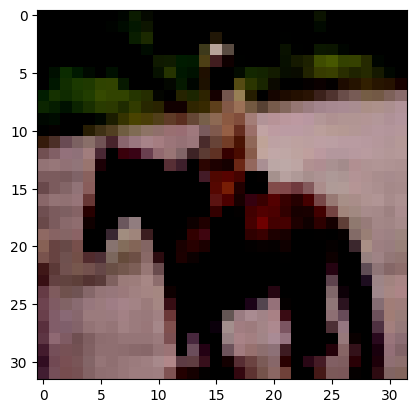

In [4]:
#%% load cfar images, download through torch
import torchvision
import torchvision.transforms as transforms

# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                            shuffle=True)
# get an image and plot it
dataiter = iter(trainloader)
images, labels = next(dataiter)
# plot an image
plt.imshow(np.transpose(images[0], (1, 2, 0)))

# Look at example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


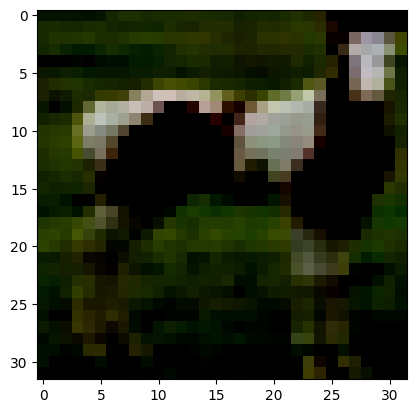

In [6]:

# get an image and plot it
dataiter = iter(trainloader)
images, labels = next(dataiter)
# plot an image
plt.imshow(np.transpose(images[0], (1, 2, 0)))

image_shape = images[0].shape
# print image shape
print(image_shape)


# Instantiate Model and Train

In [7]:

model = PredictiveCodingNetwork(input_size=(3, image_shape[1], image_shape[2]), 
                n_layers=2, n_causes=[8, 10], kernel_size=[[8,8],[3,3]], stride=[4, 2], padding=0,
                    lam=0.1, alpha=0.1, k1=.005, k2=0.05, sigma2=10.)

x = images
for i in range(10):
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    _ = model(x, timesteps=i*10, train_U=True)

    # decrease k2 by dividing by 1.05
    for layer in model.layers:
        layer.k2 /= 1.05

0it [00:00, ?it/s]
total_loss: 57956.977, reconstruction_loss: 57956.676, mean_abs_error: 0.384: 100%|██████████| 10/10 [00:01<00:00,  9.04it/s] 
total_loss: 25697.066, reconstruction_loss: 25696.744, mean_abs_error: 0.242: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s] 
total_loss: 21856.982, reconstruction_loss: 21856.658, mean_abs_error: 0.224: 100%|██████████| 30/30 [00:02<00:00, 10.28it/s] 
total_loss: 18995.613, reconstruction_loss: 18995.201, mean_abs_error: 0.210: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s] 
total_loss: 16979.996, reconstruction_loss: 16979.604, mean_abs_error: 0.204: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s] 
total_loss: 15298.081, reconstruction_loss: 15297.683, mean_abs_error: 0.198: 100%|██████████| 60/60 [00:05<00:00, 10.05it/s] 
total_loss: 14408.011, reconstruction_loss: 14407.606, mean_abs_error: 0.192: 100%|██████████| 70/70 [00:06<00:00, 10.14it/s] 
total_loss: 14323.529, reconstruction_loss: 14323.096, mean_abs_error: 0.189: 100%|█████████

## Visualize first layer features

(8, 3, 8, 8)


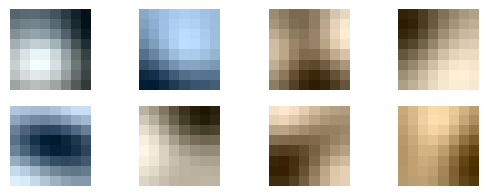

In [8]:

# get U from the first layer
U0 = model.layers[0].U.detach().numpy()
# shape of U is (n_causes, channels, kernel_height, kernel_width)
print(U0.shape)
# viusalize the first 16 causes
for i in range(8):
    plt.subplot(4, 4, i+1)
    to_plot = U0[i, :, :, :] #  (channels, kernel_height, kernel_width)
    # make sure image is between 0 and 1
    to_plot = (to_plot - to_plot.min())/(to_plot.max() - to_plot.min())
    to_plot = np.transpose(to_plot, (1, 2, 0)) # (kernel_height, kernel_width, channels)
    plt.imshow(to_plot)
    plt.axis('off')

# Look at predictions and prediction errors


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
total_loss: 15142.592, reconstruction_loss: 15142.163, mean_abs_error: 0.204: 100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


(500, 8, 7, 7)
(8, 3, 8, 8)
(500, 3, 8, 8, 7, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction')

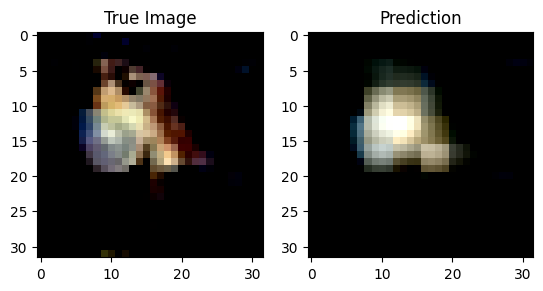

In [9]:
# take a single image
# get the next dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
image = images[0]
# lets look at it in a subplot
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image, (1, 2, 0)))

# lets run the batch through the network
x = images 
x = model(x, timesteps=100, train_U=False)

# get the finale value of r in the first layer
r0 = model.layers[0].r.detach().numpy()
# shape of r is (batch_size, n_causes, n_patches_h, n_patches_w)
print(r0.shape)
# get the final value of U in the first layer
U0 = model.layers[0].U.detach().numpy()
# shape of U is (n_causes, channels, kernel_height, kernel_width)
print(U0.shape)

# combine U0 and r0 to get the final value of the first layer
# shape of x_hat is (batch_size, channels, height, width)
prediction = einsum('causes chan kernh kernw, batch causes npatchesh npatchesw -> batch chan kernh kernw npatchesh npatchesw', U0, r0)
print(prediction.shape) # (batch_size, channels, height, width, n_patches_h, n_patches_w)
# fold this back up to be an image
# get the unfold from the first layer
unfold = model.layers[0].unfold
# get the unfold params
unfold_params = unfold.parameters()
# PRINT THE PARAMS
# get stride of the unfold
stride = unfold.stride
fold = torch.nn.Fold((32,32), kernel_size=unfold.kernel_size, stride=stride)
# input_ones is a torch.ones with size (batch_size, channels, height, width)
input_ones = torch.ones(x.shape)
prediction = prediction.reshape(prediction.shape[0], prediction.shape[1]*prediction.shape[2]*prediction.shape[3], prediction.shape[4]*prediction.shape[5])
# rewrite the previous line
# fold the prediction, conver to torch
prediction = fold(torch.from_numpy(prediction))
# we have to divide the prediction because of fold
divisor = fold(unfold(input_ones))
prediction = prediction / divisor

# look at the prediction in other subplot
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(prediction[0].detach().numpy(), (1, 2, 0)))
# put a title that is the label
# put a title on the left for the original image
plt.subplot(1, 2, 1)
plt.title('True Image')
# put a title on the right for the prediction
plt.subplot(1, 2, 2)
plt.title('Prediction')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

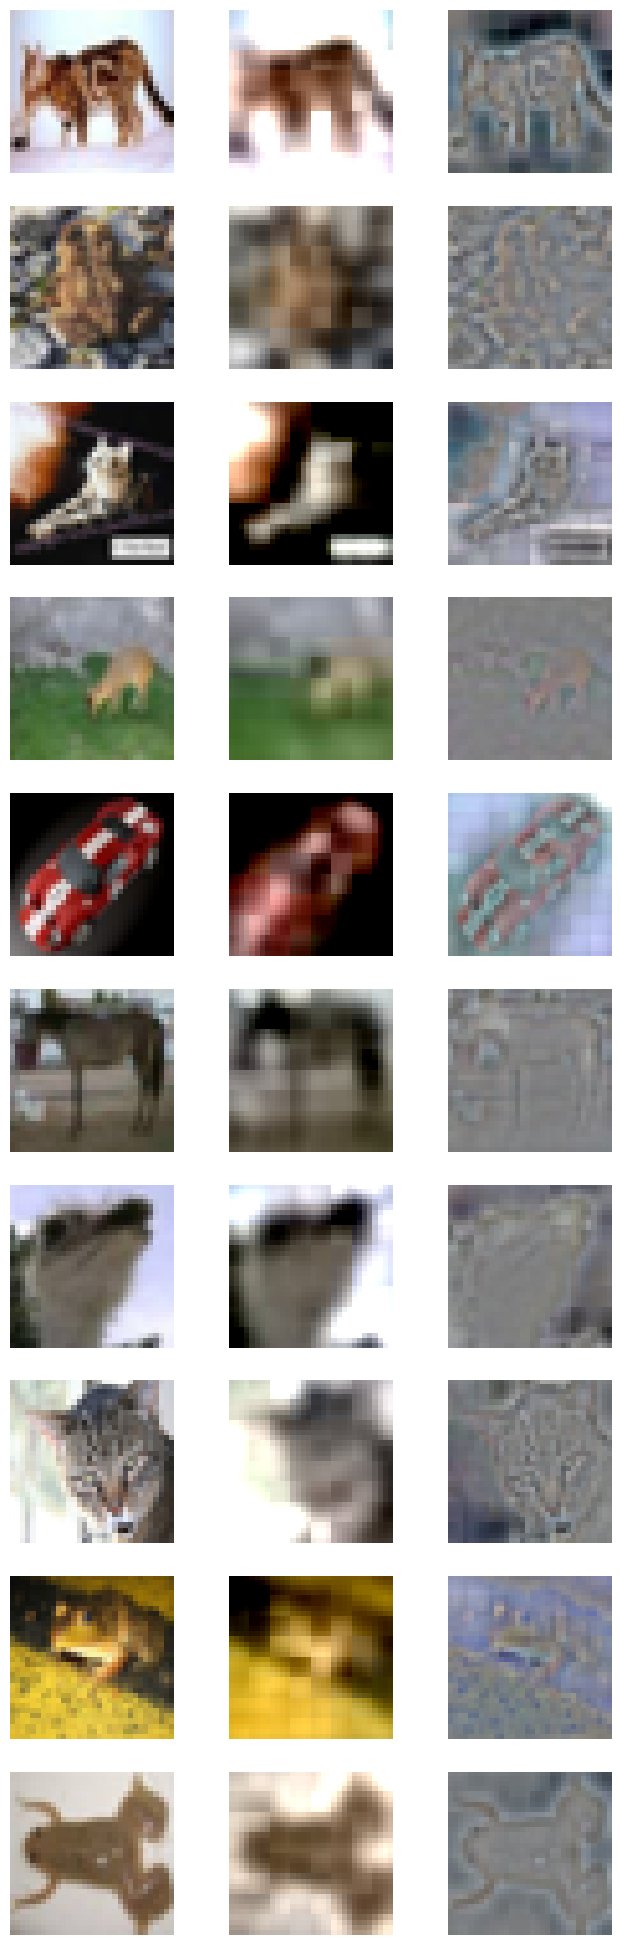

In [6]:
# now make a figure that shows the original image, the prediction, and the difference
# and does it for 10 images, we already have all the predictions, no need to run the network again
# dont get another dataset
# the true image is in one column, the prediction is in the next column, and the difference is in the next column
figure = plt.figure(figsize=(8, 25))
for i in range(10):
    # get the next subplot
    plt.subplot(10, 3, 3*i+1)
    # rescale all the images from -1 to 1 to 0 to 1
    im = images[i]
    im = (im + 1) / 2
    pred = prediction.detach().numpy()[i]
    pred = (pred + 1) / 2
    error = im - pred
    error = (error + 1) / 2
    

    # plot the true image
    plt.imshow(np.transpose(im, (1, 2, 0)))
    # turn off the axis
    plt.axis('off')
    # get the next subplot
    plt.subplot(10, 3, 3*i+2)
    # plot the prediction
    plt.imshow(np.transpose(pred, (1, 2, 0)))
    # turn off the axis
    plt.axis('off')
    # get the next subplot
    plt.subplot(10, 3, 3*i+3)
    # plot the difference
    # convert the image to numpy
    # convert the prediction to numpy
    # convert the error to numpy
    # plot the error
    plt.imshow(np.transpose(error, (1, 2, 0)))
    # turn off the axis
    plt.axis('off')